<a href="https://colab.research.google.com/github/mkjubran/AI-Assisted-Physical-Rehabilitation-using-Pause-Detection/blob/main/AI_Assisted_Physical_Therapy_using_Pause_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load some libraries needed for the execution of the code

In [38]:
import os
import numpy as np

Load the dataset from google drive

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read all .npz files in the folder PHVideoDataSet_2D3D_Blurred/3D/ into a dictionary PHV3DB

In [40]:
PHV3DB={} #PHVideoDataSet_2D3D_Blurred/3D
directory = '/content/drive/MyDrive/PHVideoDataSet_2D3D_Blurred/3D/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
       a = np.load(f)
       PHV3DB[filename.split('_a')[0]]=a['reconstruction'][0,:,:,:]

Read all .npz files in the folder PHVideoDataSet_2D3D_Blurred/2D/ into a dictionary PHV2DB

In [41]:
PHV2DB={} #PHVideoDataSet_2D3D_Blurred/2D
directory = '/content/drive/MyDrive/PHVideoDataSet_2D3D_Blurred/2D/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
       a = np.load(f)
       PHV2DB[filename.split('_a')[0]]=a['reconstruction'][0,:,:,:]

compute the energy in PHV2DB and PHV3DB and then plot a sample exercises. This wil be used later for motion segmentation. 

In [42]:
PHV2DB_Energy={}
for k in PHV2DB.keys():
   PHV2DB_Energy[k]=np.square(PHV2DB[k]).sum(axis=1).sum(axis=1)

In [43]:
PHV3DB_Energy={}
for k in PHV3DB.keys():
   PHV3DB_Energy[k]=np.square(PHV3DB[k]).sum(axis=1).sum(axis=1)

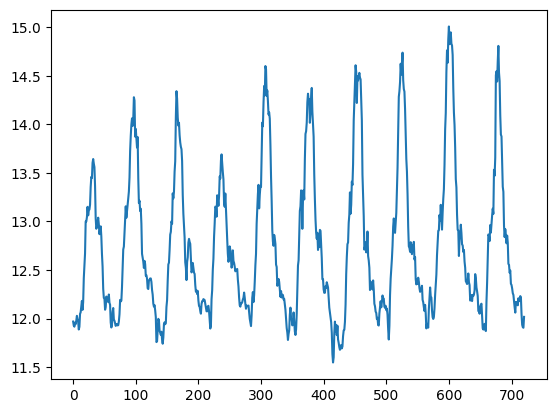

In [44]:
import matplotlib.pyplot as plt
plt.plot(PHV3DB_Energy['E0_P0_T0_C1'])

Use Gaussina Filter to smooth the signal

In [45]:
def gkernel_1D(l=3, sig=1):
    """\
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)

    kernel = np.exp(-0.5 * (np.square(ax)) / np.square(sig))

    return kernel / np.sum(kernel)

Apply Gaussian filter to smoothen PHV2DB

In [46]:
b = gkernel_1D(7,1)
PHV2DBsmooth=PHV2DB.copy()
for k in PHV2DB.keys():
  for joint_cnt in range(PHV2DB[k].shape[1]):
    for axis_cnt in range(PHV2DB[k].shape[2]):
      PHV2DBsmooth[k][:,joint_cnt,axis_cnt]= np.convolve(PHV2DB[k][:,joint_cnt,axis_cnt],b)[3:-3] # floor of 5/2

Apply Gaussian filter to smoothen PHV3DB

In [47]:
b = gkernel_1D(7,1)
PHV3DBsmooth=PHV3DB.copy()
for k in PHV3DB.keys():
  for joint_cnt in range(PHV3DB[k].shape[1]):
    for axis_cnt in range(PHV3DB[k].shape[2]):
      PHV3DBsmooth[k][:,joint_cnt,axis_cnt]= np.convolve(PHV3DB[k][:,joint_cnt,axis_cnt],b)[3:-3] # floor of 5/2

Compute the energy in smoothed verison of PHV2DB and PHV3DB and then plot a sample exercises. This wil be used later for motion segmentation. 

In [48]:
PHV2DBsmooth_Energy={}
for k in PHV2DBsmooth.keys():
   PHV2DBsmooth_Energy[k]=np.square(PHV2DBsmooth[k]).sum(axis=1).sum(axis=1)

In [49]:
PHV3DBsmooth_Energy={}
for k in PHV3DBsmooth.keys():
   PHV3DBsmooth_Energy[k]=np.square(PHV3DBsmooth[k]).sum(axis=1).sum(axis=1)

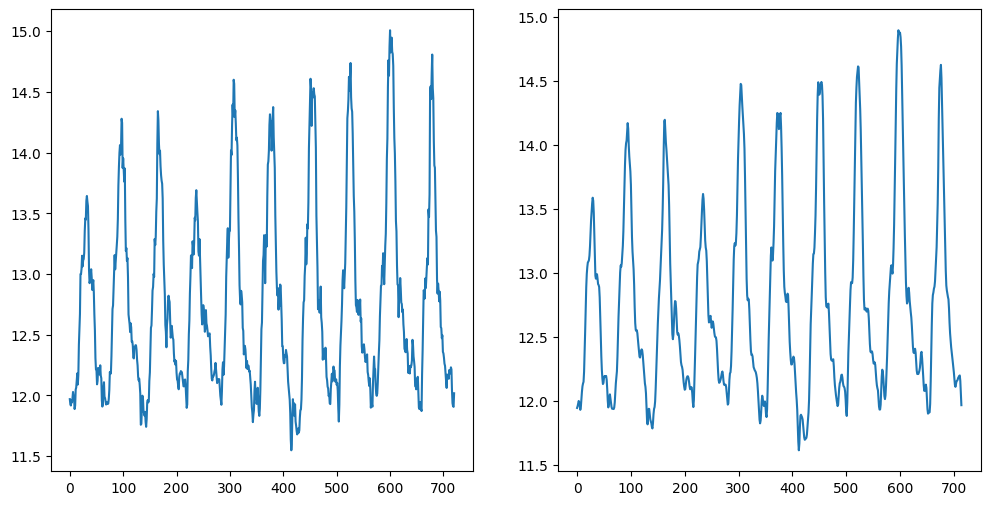

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(PHV3DB_Energy['E0_P0_T0_C1'])

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(PHV3DBsmooth_Energy['E0_P0_T0_C1'][3:-3])

Compute the first derivative of PHV2DBsmooth and PHV3DBsmooth .... if needed

In [63]:
PHV3DBsmooth_1std={}
for k in PHV3DBsmooth.keys():
  for frame_cnt in range(2,PHV3DBsmooth[k].shape[0]-2):
    if frame_cnt == 2:
      tmp=PHV3DBsmooth[k][frame_cnt-1]-PHV3DBsmooth[k][frame_cnt]
      tmp = tmp[np.newaxis,:,:]
    else:
      tmp2=PHV3DBsmooth[k][frame_cnt-1]-PHV3DBsmooth[k][frame_cnt]
      tmp2= tmp2[np.newaxis,:,:]
      tmp=np.concatenate((tmp,tmp2))
  PHV3DBsmooth_1std[k]=tmp

In [64]:
PHV2DBsmooth_1std={}
for k in PHV2DBsmooth.keys():
  for frame_cnt in range(2,PHV2DBsmooth[k].shape[0]-2):
    if frame_cnt == 2:
      tmp=PHV2DBsmooth[k][frame_cnt-1]-PHV2DBsmooth[k][frame_cnt]
      tmp = tmp[np.newaxis,:,:]
    else:
      tmp2=PHV2DBsmooth[k][frame_cnt-1]-PHV2DBsmooth[k][frame_cnt]
      tmp2= tmp2[np.newaxis,:,:]
      tmp=np.concatenate((tmp,tmp2))
  PHV2DBsmooth_1std[k]=tmp

Compute the second derivative of PHV2DBsmooth and PHV3DBsmooth  .... if needed

In [65]:
PHV3DBsmooth_2ndd={}
for k in PHV3DBsmooth.keys():
  for frame_cnt in range(2,PHV3DBsmooth[k].shape[0]-2):
    if frame_cnt == 2:
      tmp=PHV3DBsmooth[k][frame_cnt-2]+PHV3DBsmooth[k][frame_cnt+2]-2*PHV3DBsmooth[k][frame_cnt]
      tmp = tmp[np.newaxis,:,:]
    else:
      tmp2=PHV3DBsmooth[k][frame_cnt-2]+PHV3DBsmooth[k][frame_cnt+2]-2*PHV3DBsmooth[k][frame_cnt]
      tmp2= tmp2[np.newaxis,:,:]
      tmp=np.concatenate((tmp,tmp2))
  PHV3DBsmooth_2ndd[k]=tmp

In [66]:
PHV2DBsmooth_2ndd={}
for k in PHV2DBsmooth.keys():
  for frame_cnt in range(2,PHV2DBsmooth[k].shape[0]-2):
    if frame_cnt == 2:
      tmp=PHV2DBsmooth[k][frame_cnt-2]+PHV2DBsmooth[k][frame_cnt+2]-2*PHV2DBsmooth[k][frame_cnt]
      tmp = tmp[np.newaxis,:,:]
    else:
      tmp2=PHV2DBsmooth[k][frame_cnt-2]+PHV2DBsmooth[k][frame_cnt+2]-2*PHV2DBsmooth[k][frame_cnt]
      tmp2= tmp2[np.newaxis,:,:]
      tmp=np.concatenate((tmp,tmp2))
  PHV2DBsmooth_2ndd[k]=tmp